This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

# 1. Import Libraries

Contains used libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt

# For Visualization Needs
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# For Feature Engineering
from sklearn.model_selection import train_test_split

# 2. Data Loading

The process involves preparing data before conducting further data exploration. Data Loading may include checking the dataset's size, etc.

In [2]:
# Load Data
data = pd.read_excel('Online_Retail.xlsx')

## Data Information

In [3]:
# Show All Data
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Show Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The displayed data contains 8 columns and 541,908 rows, there are 1 column of datetime64 type, 2 columns of float64 type, 1 column of int64 type, and 4 columns object type.

| Column Name | Data Type | Description |
|---|---|---|
| `InvoiceNo` | object | a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation |
| `StockCode` | object | a 5-digit integral number uniquely assigned to each distinct product |
| `Description` | object | product name |
| `Quantity` | int64 | the quantities of each product (item) per transaction |
| `InvoiceDate` | datetime64[ns] | the day and time when each transaction was generated |
| `UnitPrice` | float64 | product price per unit |
| `CustomerID` | float64 | a 5-digit integral number uniquely assigned to each customer |
| `Country` | object | the name of the country where each customer resides |

# 3. Exploratory Data Analysis (EDA)

# 4. Feature Engineering

## 4.1 Pra-processing Data

### A. Checking Missing Values

In [5]:
# Missing Values Check
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### B. Checking Data Duplicate 

In [6]:
# Checking data duplicate
data.duplicated().sum()

5268

In [7]:
# Dictionary saving results
columns_with_duplicates = {}

# Iteration each columns for checking data duplicate
for column in data.columns:
    if data[column].duplicated().any():  # Cek jika ada duplikat di kolom tersebut
        columns_with_duplicates[column] = True
    else:
        columns_with_duplicates[column] = False

# Show columns with data duplicate
for column, has_duplicates in columns_with_duplicates.items():
    if has_duplicates:
        print(f"Kolom '{column}' have data dupicate.")
    else:
        print(f"Kolom '{column}' don't have data duplicate.")

Kolom 'InvoiceNo' have data dupicate.
Kolom 'StockCode' have data dupicate.
Kolom 'Description' have data dupicate.
Kolom 'Quantity' have data dupicate.
Kolom 'InvoiceDate' have data dupicate.
Kolom 'UnitPrice' have data dupicate.
Kolom 'CustomerID' have data dupicate.
Kolom 'Country' have data dupicate.


# Exploratory Data Anlysis (EDA)

## 1. Segmentasi RFM (Recency, Frequency, Monetary)

In [8]:
# Menghitung R, F, M
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
current_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

RFM = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'MonetaryValue'})

# Aplikasikan segmentasi menggunakan metode quartil
quartiles = RFM.quantile([0.25, 0.5, 0.75])
def r_score(x): return 4 if x <= quartiles['Recency'][0.25] else 3 if x <= quartiles['Recency'][0.5] else 2 if x <= quartiles['Recency'][0.75] else 1
def fm_score(x, c): return 1 if x <= quartiles[c][0.25] else 2 if x <= quartiles[c][0.5] else 3 if x <= quartiles[c][0.75] else 4

RFM['R'] = RFM['Recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
RFM['M'] = RFM['MonetaryValue'].apply(lambda x: fm_score(x, 'MonetaryValue'))

# Menggabungkan R, F, M dengan membuat RFM['Segment']
RFM['Segment'] = RFM['R'].astype(str) + RFM['F'].astype(str) + RFM['M'].astype(str)


<Axes: title={'center': 'RFM Segment Distribution'}, xlabel='Segment'>

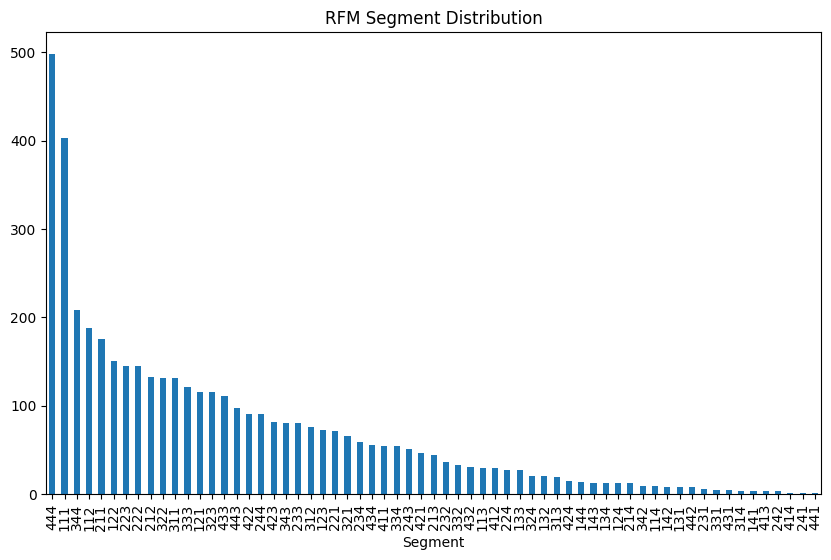

In [9]:
# Diasumsikan RFM sudah dihitung dan disegmentasi
RFM['Segment'].value_counts().plot(kind='bar', figsize=(10,6), title='RFM Segment Distribution')

## 2. Analisis Kohort

In [10]:
# Tentukan kohort bulanan berdasarkan InvoiceDate
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')
data['Cohort'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

cohort_data = data.groupby(['Cohort', 'InvoiceMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
cohort_data['PeriodNumber'] = (cohort_data['InvoiceMonth'] - cohort_data['Cohort']).apply(lambda x: x.n)

# Pivot data untuk analisis kohort
cohort_pivot = cohort_data.pivot_table(index = 'Cohort', columns = 'PeriodNumber', values = 'n_customers')

# Hitung retensi sebagai persentase
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


Text(0.5, 1.0, 'Retensi Pelanggan per Kohort')

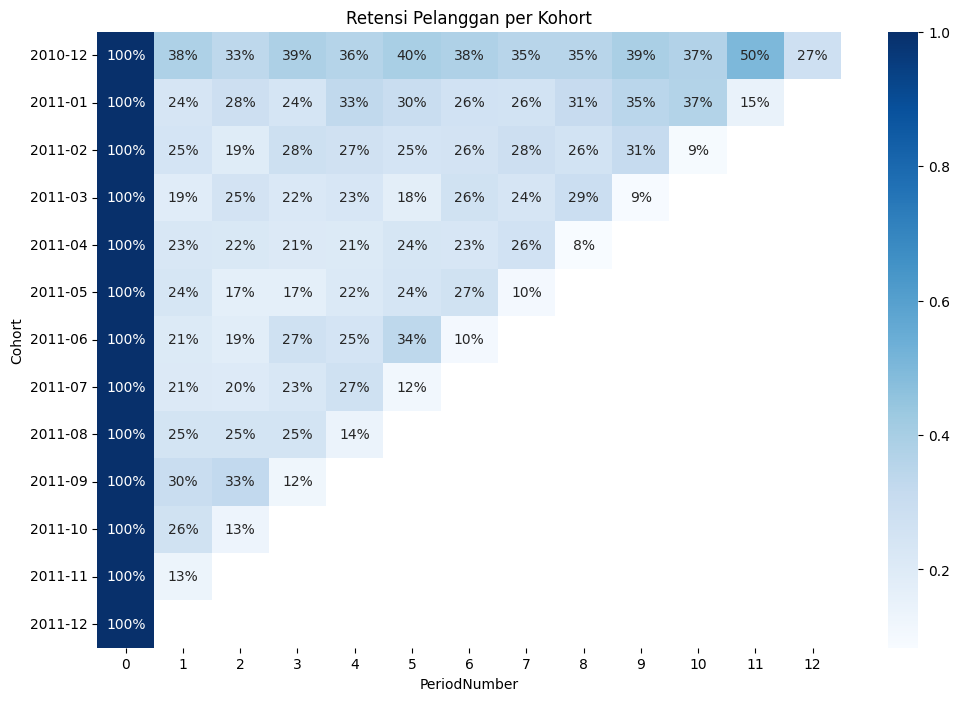

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Retensi Pelanggan per Kohort')

## 3. Analisis Pareto (80/20 Rule)

Identifikasi 20% pelanggan yang menghasilkan 80% dari pendapatan total untuk menargetkan upaya pemasaran.

In [12]:
cumulative_revenue = RFM['MonetaryValue'].sort_values(ascending=False).cumsum()
cumulative_percent = cumulative_revenue / cumulative_revenue.max()
pareto_threshold = cumulative_percent[cumulative_percent > 0.8].index[0]

# Pelanggan di atas threshold ini adalah top 20% contributor
top_20_contributors = RFM[RFM.index <= pareto_threshold]

/var/folders/48/b9jzlynd2_s0_mfh91zh45pm0000gn/T/ipykernel_592/3691109078.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cumulative_percent, hist=True, kde=True)


Text(0.5, 1.0, 'Distribusi Kumulatif Pendapatan (Pareto)')

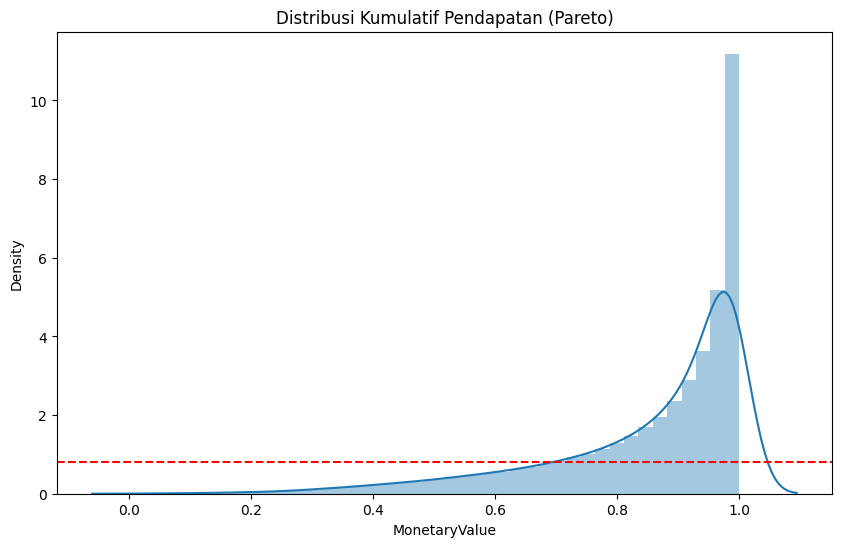

In [13]:
plt.figure(figsize=(10, 6))
sns.distplot(cumulative_percent, hist=True, kde=True)
plt.axhline(0.8, color='red', linestyle='--')
plt.title('Distribusi Kumulatif Pendapatan (Pareto)')

/var/folders/48/b9jzlynd2_s0_mfh91zh45pm0000gn/T/ipykernel_592/3691109078.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cumulative_percent, hist=True, kde=True)


Text(0.5, 1.0, 'Distribusi Kumulatif Pendapatan (Pareto)')

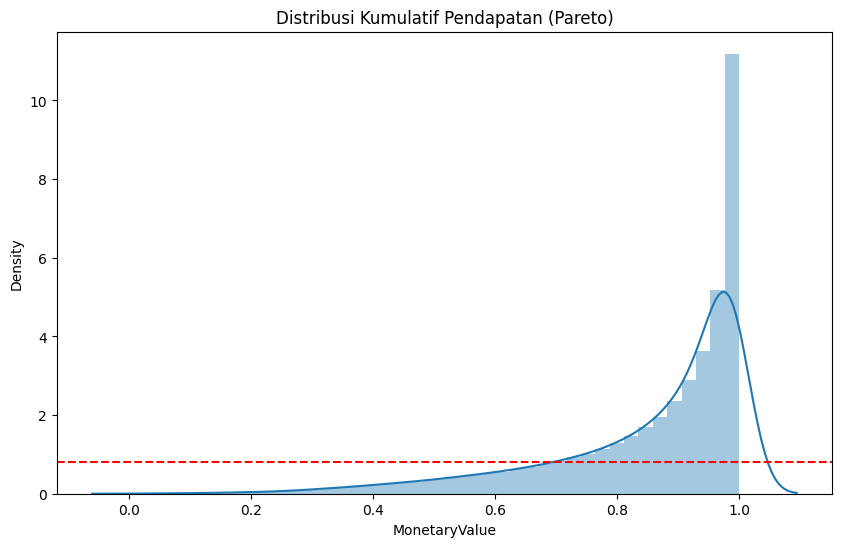

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(cumulative_percent, hist=True, kde=True)
plt.axhline(0.8, color='red', linestyle='--')
plt.title('Distribusi Kumulatif Pendapatan (Pareto)')

## 4. Analisis Produk Terlaris per Segmen Pelanggan

Menganalisis produk yang paling banyak dibeli oleh segmen pelanggan tertentu, seperti pelanggan dengan nilai RFM tinggi.

In [15]:
# Identifikasi segmen pelanggan terlebih dahulu seperti pada Segmentasi RFM
# Kemudian filter data berdasarkan segmen tersebut
top_segment_customers = RFM[RFM['Segment'] == '444'] # Cont

Text(0.5, 1.0, 'Produk Terlaris per Segmen Pelanggan')

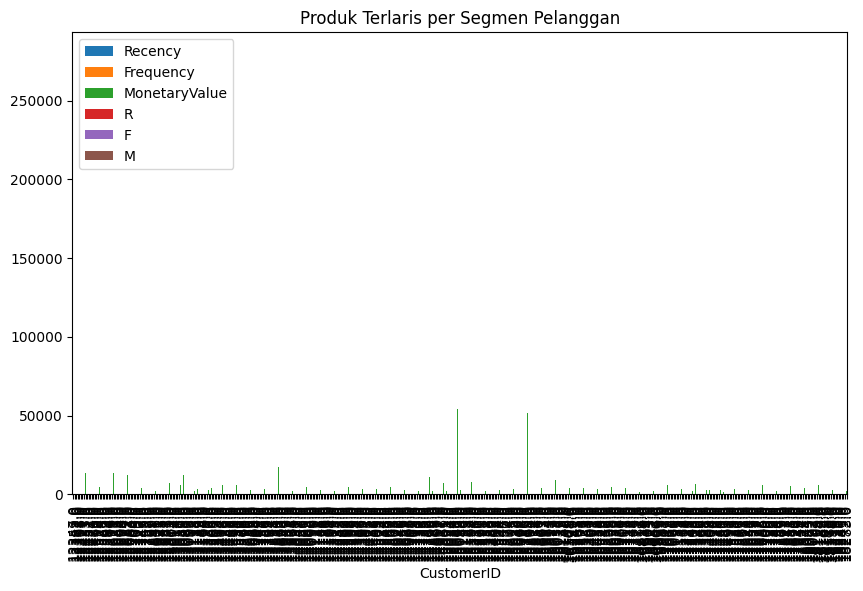

In [16]:
# Diasumsikan data produk terlaris per segmen sudah dihitung
top_segment_customers.plot(kind='bar', figsize=(10,6))
plt.title('Produk Terlaris per Segmen Pelanggan')

## 5. Analisis Perubahan Harga Terhadap Volume Penjualan

Membandingkan bagaimana perubahan harga mempengaruhi jumlah produk yang terjual, untuk menentukan sensitivitas harga pelanggan.

In [17]:
# Menghitung rata-rata harga dan jumlah penjualan per produk
price_volume_analysis = data.groupby('StockCode').agg(avg_price=('UnitPrice', 'mean'), total_quantity=('Quantity', 'sum')).reset_index()

# Analisis korelasi antara avg_price dan total_quantity
price_volume_correlation = price_volume_analysis['avg_price'].corr(price_volume_analysis['total_quantity'])

Text(0.5, 1.0, 'Korelasi antara Harga Rata-rata dan Volume Penjualan')

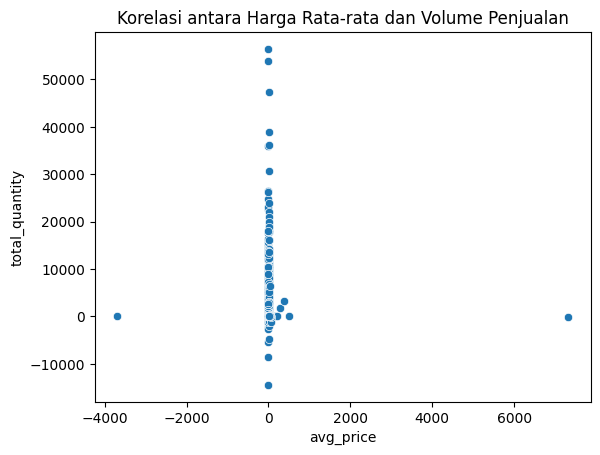

In [18]:
sns.scatterplot(data=price_volume_analysis, x='avg_price', y='total_quantity')
plt.title('Korelasi antara Harga Rata-rata dan Volume Penjualan')

## 6. Analisis Waktu Pembelian

Menentukan jam atau hari dalam seminggu ketika pelanggan paling sering melakukan pembelian, untuk mengoptimalkan waktu pengiriman email marketing atau promosi.

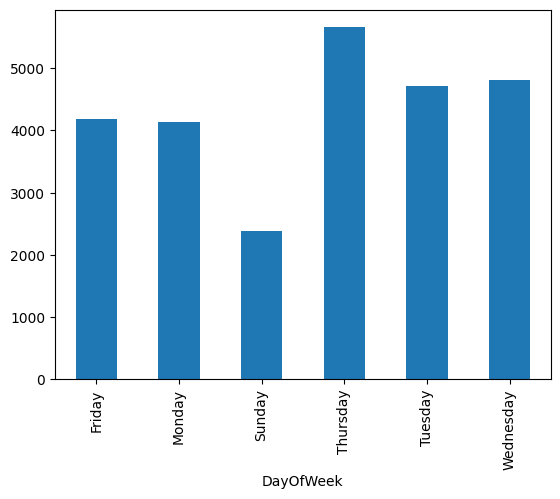

In [19]:
# Ekstrak hari dan jam dari InvoiceDate
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()

# Menghitung jumlah faktur per jam dan hari
hourly_sales = data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar')
daily_sales = data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar')

Text(0.5, 1.0, 'Jumlah Pembelian per Hari')

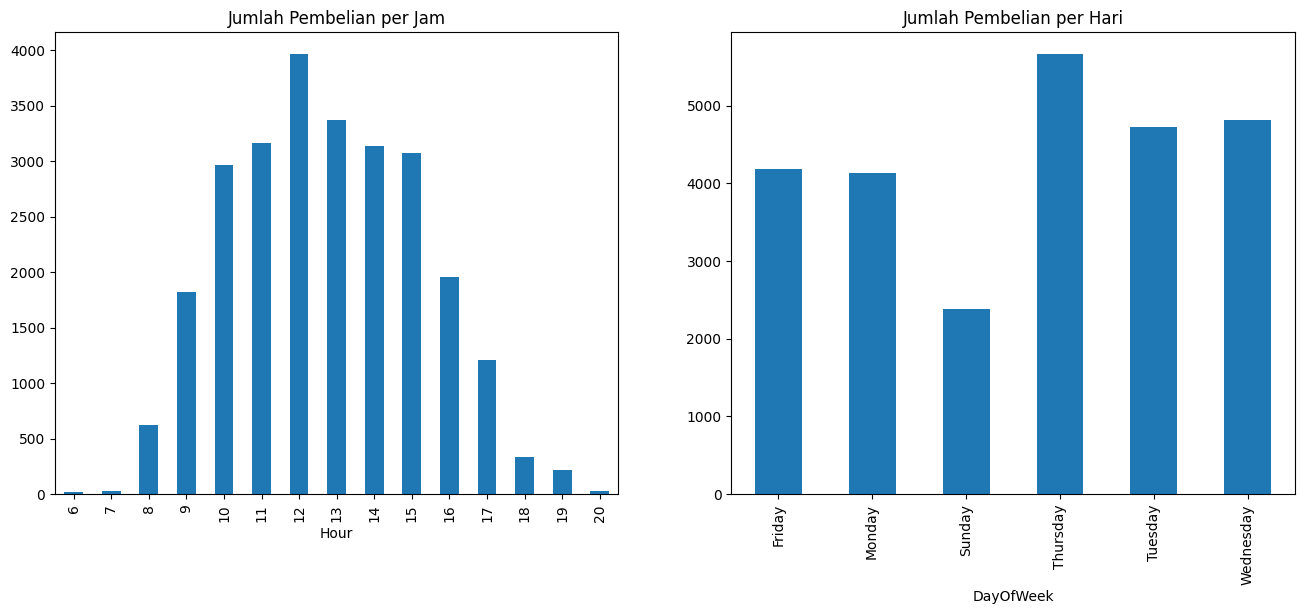

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[0])
ax[0].set_title('Jumlah Pembelian per Jam')
data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[1])
ax[1].set_title('Jumlah Pembelian per Hari')

## 7. Analisis Pengaruh Negara Terhadap RFM

Membandingkan skor RFM antar negara untuk melihat bagaimana perilaku pembelian berbeda di berbagai pasar.

In [21]:
RFM_country = data.groupby(['Country', 'CustomerID']).agg(
    Recency=('InvoiceDate', lambda x: (current_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    MonetaryValue=('TotalPrice', 'sum')
).groupby('Country').mean()

array([[<Axes: title={'center': 'Recency'}, xlabel='Country'>,
        <Axes: title={'center': 'Frequency'}, xlabel='Country'>,
        <Axes: title={'center': 'MonetaryValue'}, xlabel='Country'>]],
      dtype=object)

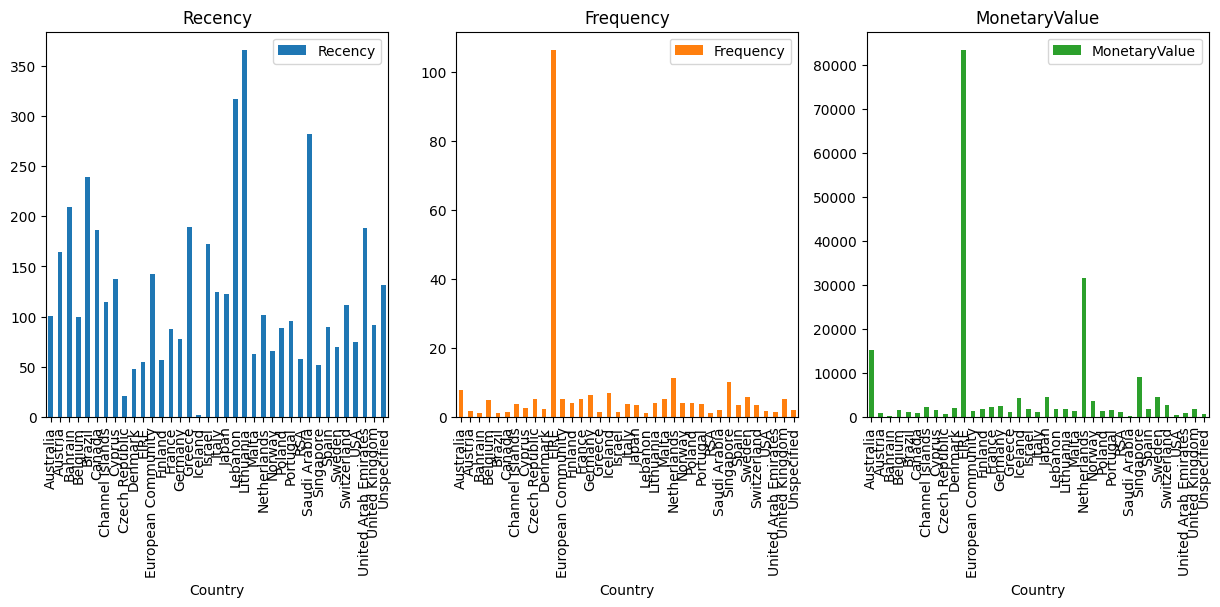

In [22]:
# # Menghitung R, F, M per negara
# RFM_country = data.groupby(['Country', 'CustomerID']).agg({
#     'InvoiceDate': lambda x: (current_date - x.max()).days,
#     'InvoiceNo': 'nunique',
#     'TotalPrice': 'sum'
# }).groupby('Country').mean()

# Visualisasi R, F, M rata-rata per negara
RFM_country[['Recency', 'Frequency', 'MonetaryValue']].plot(kind='bar', subplots=True, layout=(1,3), figsize=(15, 5))

Text(0.5, 0.98, 'RFM Rata-rata per Negara')

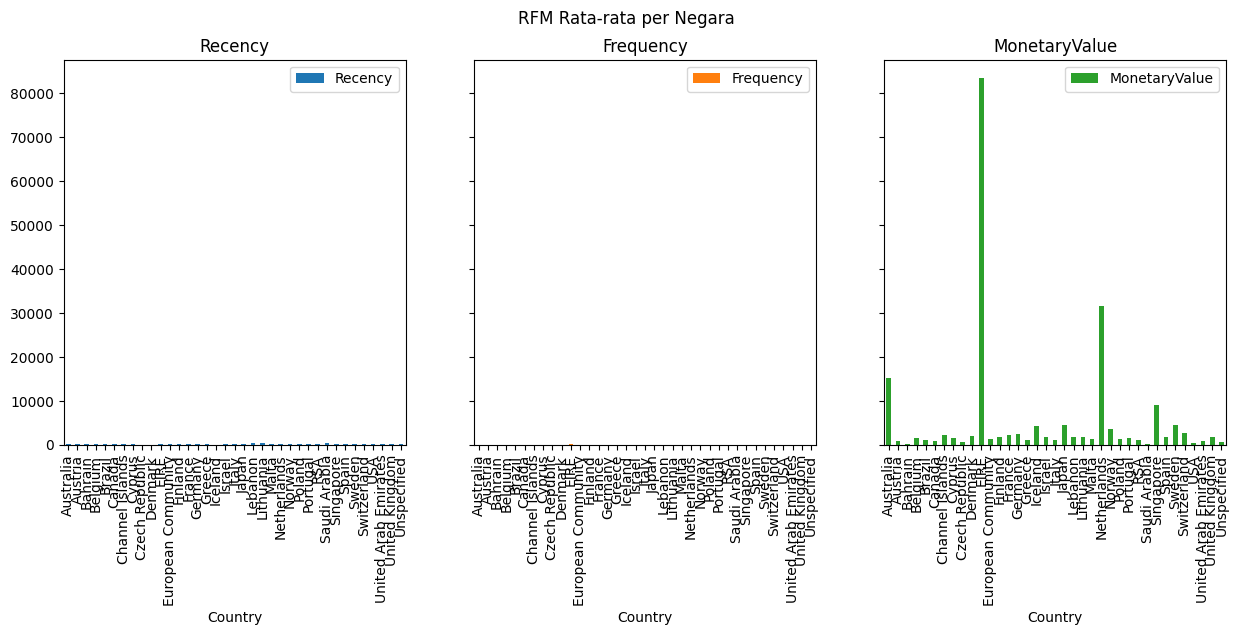

In [23]:
RFM_country[['Recency', 'Frequency', 'MonetaryValue']].plot(kind='bar', subplots=True, layout=(1,3), figsize=(15, 5), sharey=True)
plt.suptitle('RFM Rata-rata per Negara')

## 8. Analisis Kategorisasi Produk

Mengkategorikan produk berdasarkan frekuensi dan volume penjualan untuk mengidentifikasi produk bintang, produk pertanyaan, produk anjing, dan produk sapi uang sesuai matriks BCG (Boston Consulting Group).

/var/folders/48/b9jzlynd2_s0_mfh91zh45pm0000gn/T/ipykernel_592/10082626.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_sales.groupby(['SalesCategory', 'FrequencyCategory']).size().unstack().plot(kind='bar', stacked=True)


<Axes: xlabel='SalesCategory'>

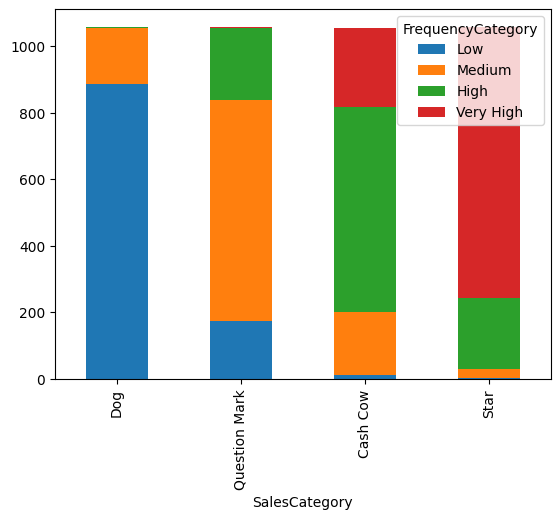

In [24]:
# Menghitung total penjualan dan frekuensi penjualan per produk
product_sales = data.groupby('Description').agg(total_sales=('Quantity', 'sum'), sales_frequency=('InvoiceNo', 'nunique'))

# Kategorisasi produk
product_sales['SalesCategory'] = pd.qcut(product_sales['total_sales'], 4, labels=['Dog', 'Question Mark', 'Cash Cow', 'Star'])
product_sales['FrequencyCategory'] = pd.qcut(product_sales['sales_frequency'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# Visualisasi hasil kategorisasi
product_sales.groupby(['SalesCategory', 'FrequencyCategory']).size().unstack().plot(kind='bar', stacked=True)

/var/folders/48/b9jzlynd2_s0_mfh91zh45pm0000gn/T/ipykernel_592/3662471086.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_sales.groupby(['SalesCategory', 'FrequencyCategory']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))


Text(0.5, 1.0, 'Kategorisasi Produk berdasarkan Penjualan dan Frekuensi')

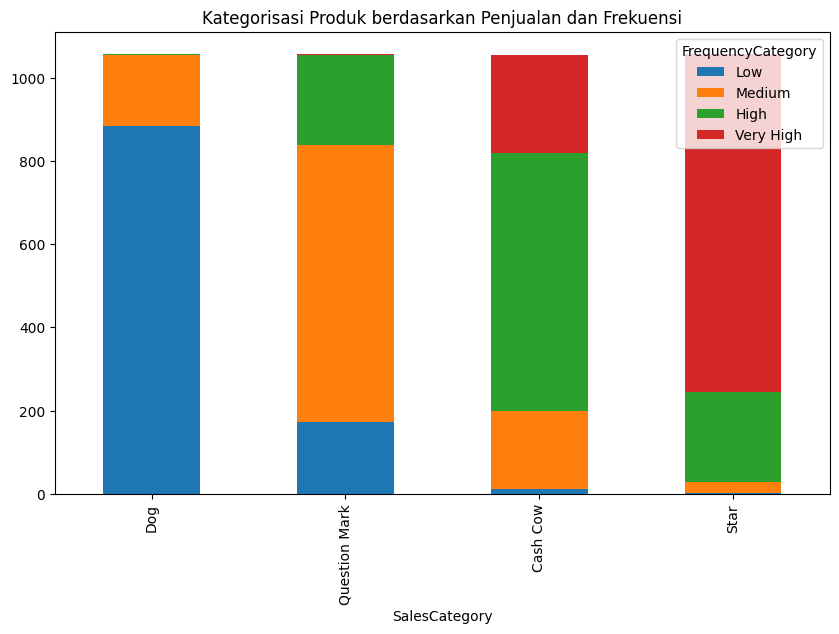

In [25]:
product_sales.groupby(['SalesCategory', 'FrequencyCategory']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Kategorisasi Produk berdasarkan Penjualan dan Frekuensi')

## 9. Analisis Retensi Pelanggan

Menentukan seberapa sering pelanggan kembali untuk melakukan pembelian lain setelah pembelian pertama mereka, untuk mengukur loyalitas pelanggan

<Axes: ylabel='Frequency'>

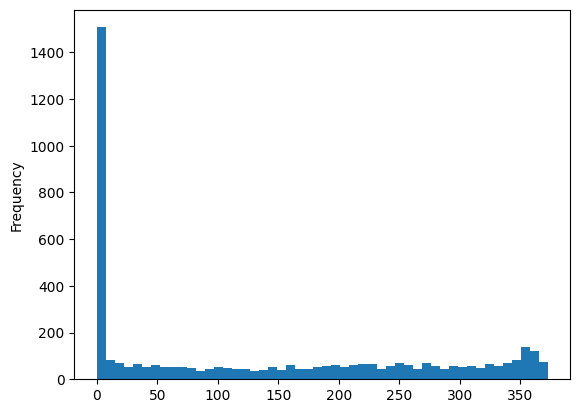

In [26]:
# Membuat kolom yang menunjukkan waktu pembelian pertama
data['FirstPurchase'] = data.groupby('CustomerID')['InvoiceDate'].transform('min')

# Menghitung selisih antara setiap pembelian dengan pembelian pertama
data['DaysSinceFirstPurchase'] = (data['InvoiceDate'] - data['FirstPurchase']).dt.days

# Analisis distribusi DaysSinceFirstPurchase untuk melihat pola retensi
retention_analysis = data.groupby('CustomerID')['DaysSinceFirstPurchase'].max().reset_index()
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50)

Text(0.5, 1.0, 'Distribusi Hari Sejak Pembelian Pertama')

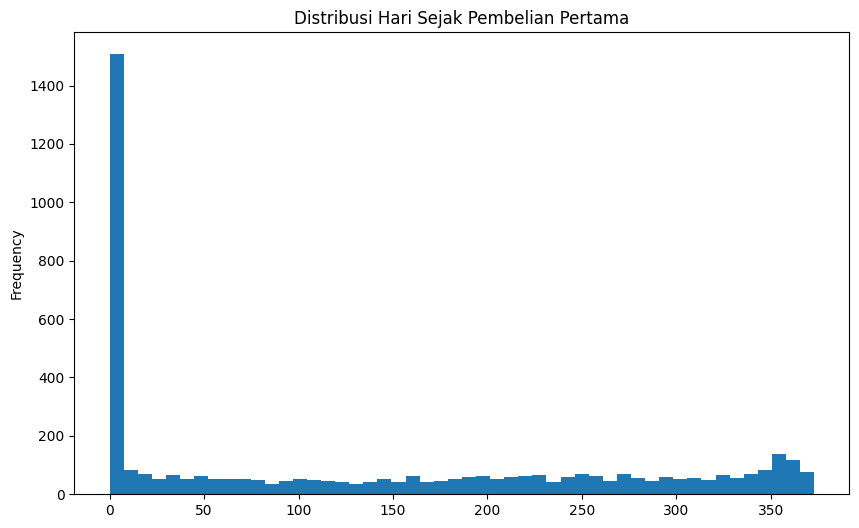

In [27]:
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribusi Hari Sejak Pembelian Pertama')